<a href="https://colab.research.google.com/github/rishi-latchmepersad/TinyML-Home-Weather-Forecasting/blob/main/machine_learning/microclimate_forecast_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%pip install  "numpy==2.0.2" "scipy==1.16.2" \
  "tensorflow==2.19.*" "keras==3.10.*" "keras-tuner==1.4.7"\
  "pandas==2.2.2" "scikit-learn==1.6.1"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.7/35.7 MB 42.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 10.0 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.16.3
    Uninstalling scipy-1.16.3:
      Successfully uninstalled scipy-1.16.3


In [2]:
# Use postponed evaluation of annotations (must be first)
from __future__ import annotations

# -----------------------------
# Standard library imports
# -----------------------------
import os
import math
import time
import json
import shutil
from datetime import date, datetime, timedelta, timezone
from pathlib import Path
from typing import Any, Callable, Dict, Iterable, List, Optional, Tuple, Union

# Configure Keras 3 to use TensorFlow as the backend BEFORE importing keras
os.environ["KERAS_BACKEND"] = "tensorflow"

# -----------------------------
# Third-party libraries
# -----------------------------
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from keras import layers, ops
from sklearn.preprocessing import StandardScaler
import keras_tuner as kt

# Determinism: seed all the things Keras knows about
keras.utils.set_random_seed(42)


In [3]:
def load_local_sensor_measurements(
    measurements_directory: Union[str, Path] = Path("measurements"),
    resample_frequency: str = "1h"
) -> pd.DataFrame:
    """
    Load captured sensor measurements from disk and convert them into an hourly dataset.

    The CSV files contain individual sensor readings with columns:
        timestamp_iso8601, sensor, quantity, value, unit

    We pivot the long-format readings into a wide dataframe, drop unreliable sensor data,
    and aggregate to hourly means

    Args:
        measurements_directory: Folder that stores the measurement CSV files.
        resample_frequency: Pandas offset alias describing how to resample the data.

    Returns:
        A timezone-naive dataframe indexed by local timestamps with columns such as
        ['temperature', 'humidity', 'pressure', 'illuminance_lux'].
    """
    measurements_path = Path(measurements_directory)
    # read all csvs from the measurement folder
    csv_files = sorted(measurements_path.glob("*.csv"))
    if not csv_files:
        raise FileNotFoundError(f"No measurement CSV files found in {measurements_path}")

    daily_frames: list[pd.DataFrame] = []
    for csv_path in csv_files:
        daily_frame = pd.read_csv(csv_path, parse_dates=["timestamp_iso8601"])
        daily_frames.append(daily_frame)

    # concat all csvs into one
    raw_measurements = pd.concat(daily_frames, ignore_index=True)

    # remove all lines for the is_raining sensor for now
    filtered_measurements = raw_measurements.loc[
        raw_measurements["quantity"] != "is_raining"
    ].copy()

    # convert the timestamps to a datetime column type
    filtered_measurements["timestamp_iso8601"] = pd.to_datetime(
        filtered_measurements["timestamp_iso8601"],
        utc=True,
    )

    # create a pivot table to go from rows of data to columnar data
    pivoted_measurements = filtered_measurements.pivot_table(
        index="timestamp_iso8601",
        columns="quantity",
        values="value",
        aggfunc="mean",
    )

    # rename our columns for readability
    renamed_columns = pivoted_measurements.rename(
        columns={
            "temperature_c": "temperature",
            "humidity_pct": "humidity",
            "pressure_pa": "pressure",
            "lux_lx": "illuminance_lux",
        }
    )

    # ensure that our columns are labelled with strings only, and nothing like tuples
    if isinstance(renamed_columns.columns, pd.MultiIndex):
        renamed_columns.columns = renamed_columns.columns.get_level_values(-1)
    else:
        renamed_columns.columns = renamed_columns.columns.astype(str)
    # remove the axis name if present
    renamed_columns = renamed_columns.rename_axis(None, axis=1)

    # convert to TT timezone, then strip TZ info
    localized_index = renamed_columns.index.tz_convert("America/Port_of_Spain").tz_localize(None)
    renamed_columns.index = localized_index
    # rename index
    renamed_columns.index.name = "timestamp_local"


    hourly_dataframe = renamed_columns.resample(resample_frequency).mean()

    weather_dataframe = hourly_dataframe.sort_index().interpolate(limit_direction="both")

    available_columns = [
        column
        for column in ["temperature", "humidity", "pressure", "illuminance_lux"]
        if column in weather_dataframe.columns
    ]
    weather_dataframe = weather_dataframe[available_columns]

    return weather_dataframe


# Load the on-device measurements and print a quick summary for sanity checking
couva_weather_dataframe: pd.DataFrame = load_local_sensor_measurements()
print(
    couva_weather_dataframe.head(),
    couva_weather_dataframe.tail(),
    couva_weather_dataframe.shape,
)


FileNotFoundError: No measurement CSV files found in measurements

In [ ]:
# Plot each weather feature over time so we can see what it looks like
fig, axes = plt.subplots(nrows=len(couva_weather_dataframe.columns), ncols=1, figsize=(12, 15), sharex=True)

for i, col in enumerate(couva_weather_dataframe.columns):
    axes[i].plot(couva_weather_dataframe.index, couva_weather_dataframe[col])
    axes[i].set_ylabel(col)
    axes[i].grid(True)

plt.xlabel("Time")
fig.suptitle("Couva Weather Data Over Time", y=1.02, fontsize=16)
plt.tight_layout()
plt.show()

In [ ]:
# Add engineered temporal features
if "temperature" in couva_weather_dataframe.columns:
    couva_weather_dataframe['delta_T'] = couva_weather_dataframe['temperature'] - couva_weather_dataframe['temperature'].shift(1)
else:
    couva_weather_dataframe['delta_T'] = np.nan

if "pressure" in couva_weather_dataframe.columns:
    couva_weather_dataframe['delta_P'] = couva_weather_dataframe['pressure'] - couva_weather_dataframe['pressure'].shift(6)
else:
    couva_weather_dataframe['delta_P'] = np.nan

hour_of_day = couva_weather_dataframe.index.hour
couva_weather_dataframe['sin_hour'] = np.sin(2 * np.pi * hour_of_day / 24)

# Display the updated dataframe with new features
print(couva_weather_dataframe.head())

In [ ]:
def create_sliding_windows(
    feature_matrix: np.ndarray,
    target_array: np.ndarray,
    window_size: int
) -> Tuple[np.ndarray, np.ndarray]:
    """
    Create sequential sliding windows for supervised learning on time-series data.

    Args:
        feature_matrix: 2-D NumPy array [num_samples, num_features]
                        containing the input features (already normalized).
        target_array:   1-D NumPy array [num_samples] containing target values
                        (for our case, next-hour temperature).
        window_size:    Number of time steps (hours) to include per input sample.

    Returns:
        Tuple of:
          X_windows: 3-D array [num_sequences, window_size, num_features]
          y_targets: 1-D array [num_sequences] matching each input window
    """

    sequential_features: list[np.ndarray] = []  # stores each sliding window of features
    sequential_targets: list[float] = []        # stores the target value for each window

    # iterate over all possible start indices that produce a full window
    for start_index in range(len(feature_matrix) - window_size + 1):
        end_index = start_index + window_size  # end of this window

        # slice the historical portion of the data (past `window_size` hours)
        current_window: np.ndarray = feature_matrix[start_index:end_index, :]
        sequential_features.append(current_window)

        # the label is the target value *at the end* of this window
        current_target: float = target_array[end_index - 1]
        sequential_targets.append(current_target)

    # convert lists to NumPy arrays for training
    return (
        np.array(sequential_features, dtype=np.float32),
        np.array(sequential_targets, dtype=np.float32)
    )


# ---------------------------------------------------------------------
# CONFIGURATION: define how far back we look and how far ahead we predict
# ---------------------------------------------------------------------

historical_window_hours: int = 6   # number of past hours to use as input
forecast_horizon_hours: int = 1     # predict the temperature 1 hour into the future


# ---------------------------------------------------------------------
# ALIGN FEATURES AND TARGETS
# ---------------------------------------------------------------------

# Shift the temperature column forward by `forecast_horizon_hours`
# so each row’s target corresponds to a future reading.
target_series: pd.Series = couva_weather_dataframe["temperature"].shift(-forecast_horizon_hours)

# Combine features and shifted target into a single aligned DataFrame,
# then drop any NaN values caused by the shift.
combined_dataframe: pd.DataFrame = pd.concat(
    [couva_weather_dataframe, target_series.rename("target_temperature")],
    axis=1
).dropna()


# ---------------------------------------------------------------------
# NORMALIZE (STANDARDIZE) FEATURES
# ---------------------------------------------------------------------

# ML models converge faster when our inputs have zero mean and unit variance.
# We fit the scaler on *all* features (not including the target/y) and transform them.
standard_scaler: StandardScaler = StandardScaler()
normalized_features: np.ndarray = standard_scaler.fit_transform(
    combined_dataframe.drop(columns=["target_temperature"])
)

# Extract target values as a NumPy array of float32 (to match TensorFlow’s dtype).
target_values: np.ndarray = combined_dataframe["target_temperature"].to_numpy(dtype=np.float32)


# ---------------------------------------------------------------------
# BUILD SUPERVISED LEARNING WINDOWS
# ---------------------------------------------------------------------

# Remember that we always need to convert continuous time series data into overlapping sequences
# before developing ML models, to allow us to observe and build temporal patterns from the data
input_sequences, target_sequences = create_sliding_windows(
    feature_matrix=normalized_features,
    target_array=target_values,
    window_size=historical_window_hours
)


# ---------------------------------------------------------------------
# SPLIT DATASET CHRONOLOGICALLY
# ---------------------------------------------------------------------

# We never shuffle time-series data, because order matters.
# Instead, we split it into train/validation/test segments by time.
num_total_samples: int = len(input_sequences)
num_train_samples: int = int(0.70 * num_total_samples) # take 70% for training
num_validation_samples: int = int(0.85 * num_total_samples)  # then 15% for validation and the remaining 15 % for test

# Perform the splits
X_train: np.ndarray = input_sequences[:num_train_samples]
y_train: np.ndarray = target_sequences[:num_train_samples]

X_validate: np.ndarray = input_sequences[num_train_samples:num_validation_samples]
y_validate: np.ndarray = target_sequences[num_train_samples:num_validation_samples]

X_test: np.ndarray = input_sequences[num_validation_samples:]
y_test: np.ndarray = target_sequences[num_validation_samples:]


# Create a combined pool of normalized sequences for calibration.
# Using train/validation/test ensures the converter sees the full runtime distribution.
# Each sequence is standardized with the same scaler used for training/inference.
quantization_calibration_sequences: np.ndarray = np.concatenate(
    [X_train, X_validate, X_test],
    axis=0,
)
# Display shapes so we know exactly what each dataset looks like
print("Training set shape:", X_train.shape, y_train.shape)
print("Validation set shape:", X_validate.shape, y_validate.shape)
print("Test set shape:", X_test.shape, y_test.shape)

##The image below illustrates how we're using the sliding-window forecasting to predict two example features (temperature and humidity)

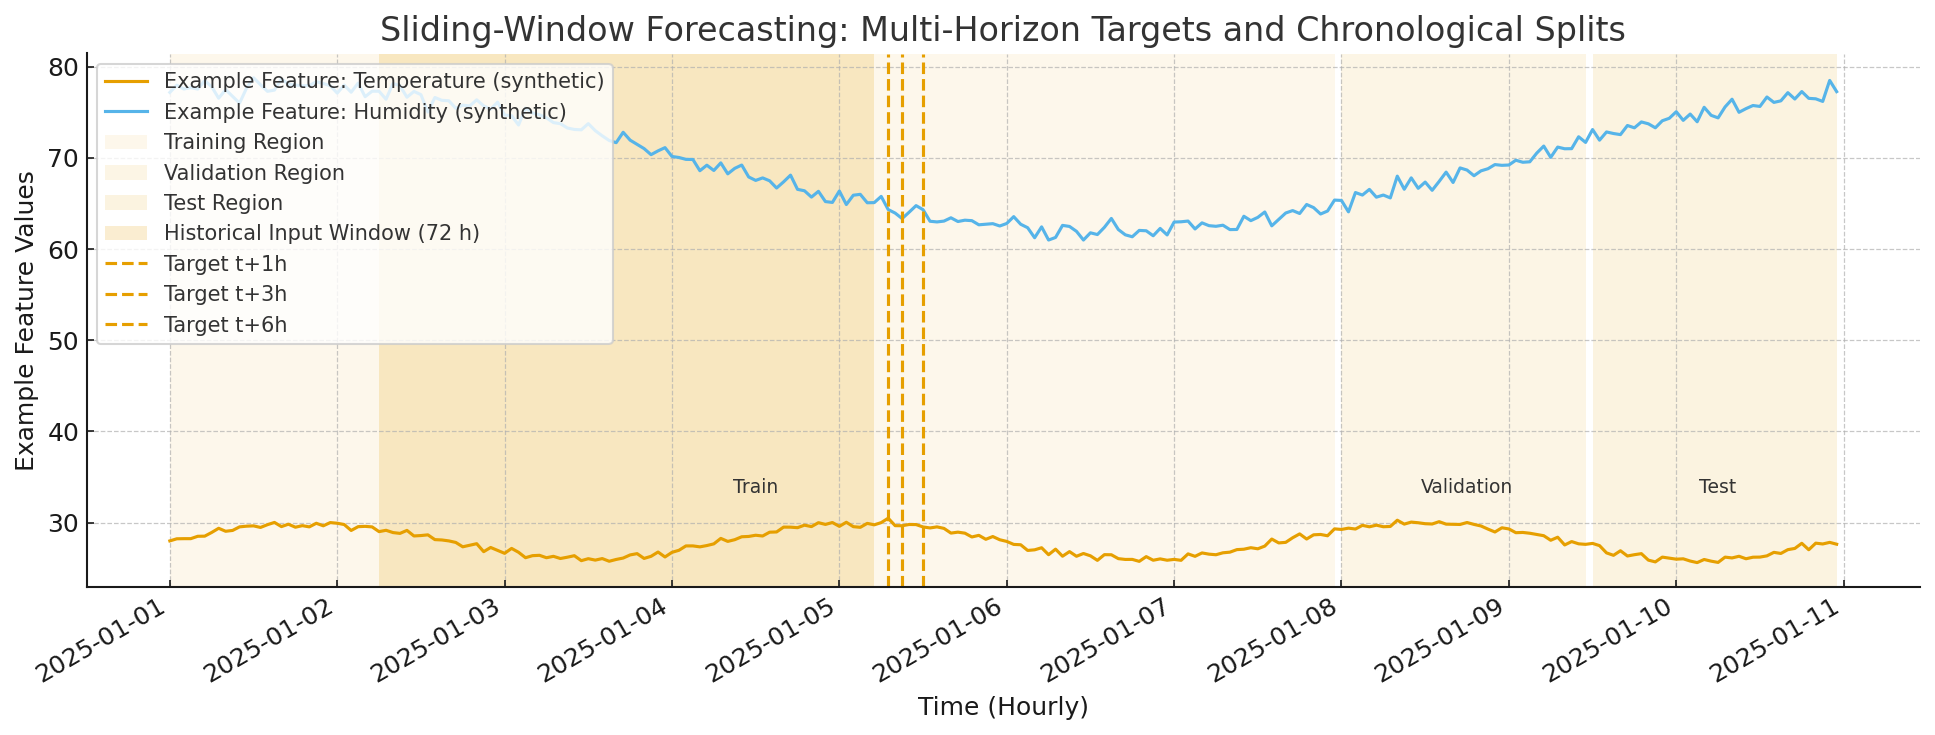

In [ ]:
def build_one_dimensional_convolutional_model(
    input_window_length: int,
    number_of_input_features: int,
    dropout_rate: float = 0.10,
    first_block_filters: int = 16,
    second_block_filters: int = 32,
) -> keras.Model:
    """
    We want to build a tiny, clean 1D CNN that predicts next-hour temperature.
    We want something we can actually deploy on a microcontroller:
      - a small parameter count so it fits comfortably,
      - enough temporal receptive field to cover our 72-hour window,
      - layers that behave nicely after INT8 quantization

    Args:
        input_window_length: how many past hours each input sample contains (e.g., 72).
        number_of_input_features: feature count per hour (temp, humidity, pressure, wind, rain = 5).
        dropout_rate: gentle regularization to keep overfitting in check.
        first_block_filters: channels for the first convolutional block.
        second_block_filters: channels for the second (separable) block.

    Returns:
        A compiled Keras regression model that outputs one scalar temperature.
    """

    # Our inputs are [time_steps, features]. Batch dimension appears at runtime.
    input_layer: keras.layers.Input = keras.Input(
        shape=(input_window_length, number_of_input_features),
        name="input_window"
    )

    # ----- Convolutional Block 1 -----
    # First pass: capture short hourly trends with a slightly wider kernel (k=5).
    convolution_1: layers.Layer = layers.Conv1D(
        filters=first_block_filters,
        kernel_size=5,
        padding="same",
        activation="relu",
        name="conv1_k5_f16"
    )(input_layer)

    # Second pass: a tighter kernel (k=3) to refine features and add nonlinearity.
    convolution_2: layers.Layer = layers.Conv1D(
        filters=first_block_filters,
        kernel_size=3,
        padding="same",
        activation="relu",
        name="conv2_k3_f16"
    )(convolution_1)

    # We downsample the time axis by 2 so the model stays lightweight.
    pooled_features_1: layers.Layer = layers.MaxPooling1D(
        pool_size=2,
        name="maxpool1_stride2"
    )(convolution_2)

    # ----- Convolutional Block 2 (separable = cheaper) -----
    # SeparableConv1D keeps accuracy decent while cutting parameters and MACs.
    separable_convolution: layers.Layer = layers.SeparableConv1D(
        filters=second_block_filters,
        kernel_size=3,
        padding="same",
        activation="relu",
        name="sepconv_k3_f32"
    )(pooled_features_1)

    # Instead of Flatten + Dense (parameter heavy), we average across time.
    global_temporal_aggregate: layers.Layer = layers.GlobalAveragePooling1D(
        name="global_average_pool"
    )(separable_convolution)

    # A touch of dropout for stability; small rate so we do not underfit.
    regularized_features: layers.Layer = layers.Dropout(
        rate=dropout_rate,
        name="dropout_regularization"
    )(global_temporal_aggregate)

    # Final linear head: give us one float, the next-hour temperature.
    output_temperature: layers.Layer = layers.Dense(
        units=1,
        dtype="float32",  # keep outputs in float32; avoids accidental dtype promotions downstream
        name="predicted_temperature"
    )(regularized_features)

    # Wire up the graph.
    model: keras.Model = keras.Model(
        inputs=input_layer,
        outputs=output_temperature,
        name="lightweight_1d_cnn_forecaster"
    )

    # Defaults that work: Adam + MSE for training, MAE for easy-to-read error in °C.
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        loss="mse",
        metrics=["mae"]
    )

    return model

In [ ]:
def build_model_for_tuning(
    hp: kt.HyperParameters,
    input_window_length: int,
    number_of_input_features: int
) -> keras.Model:
    """
    We are building a simple and flexible 1D CNN architecture for hyperparameter tuning.

    The goal here is to let Keras Tuner explore the most important parameters
    that influence model accuracy and size. We want to keep the model small enough
    for future deployment on embedded systems, while still learning useful weather patterns.

    Args:
        hp: The HyperParameters object that Keras Tuner uses during search.
        input_window_length: The number of timesteps in each input sequence.
        number_of_input_features: The number of features available per timestep.

    Returns:
        A compiled Keras model that Keras Tuner can train and evaluate.
    """

    # We start by defining the hyperparameters that the tuner will adjust.
    # These are the settings that usually make the biggest difference in model performance.

    # The dropout rate controls how much of the network we randomly deactivate during training.
    # It helps the model generalize better by preventing it from memorizing the training data.
    dropout_rate: float = hp.Float(
        "dropout_rate",
        min_value=0.0,
        max_value=0.3,
        step=0.05,
        default=0.0
    )

    # The first convolutional block sets how many filters we use for the initial feature extraction.
    # A filter count of 16 is small and efficient, but we allow the tuner to test higher values that might extract better features.
    first_block_filters: int = hp.Choice(
        "first_block_filters",
        values=[16, 32, 64],
        default=16
    )

    # The second convolutional block typically has more filters,
    # allowing the model to recognize higher-level temporal features in the data.
    second_block_filters: int = hp.Choice(
        "second_block_filters",
        values=[64, 128, 256],
        default=64
    )

    # The third block parameter is included for future flexibility.
    # Even if the base model does not always use this block,
    # having it in the search space allows us to easily expand later.
    third_block_filters: int = hp.Choice(
        "third_block_filters",
        values=[128, 256, 512],
        default=128
    )

    # The learning rate determines how large each step of the optimizer is during training.
    # Too high and we overshoot the optimal weights, too low and training becomes slow.
    learning_rate: float = hp.Choice(
        "learning_rate",
        values=[1e-2, 1e-3, 1e-4],
        default=1e-2
    )


    # Now that the tunable parameters are defined, we can build the model.
    # We pass these hyperparameters into our CNN constructor.
    model: keras.Model = build_one_dimensional_convolutional_model(
        input_window_length=input_window_length,
        number_of_input_features=number_of_input_features,
        dropout_rate=dropout_rate,
        first_block_filters=first_block_filters,
        second_block_filters=second_block_filters
    )


    # We compile the model so that it is ready for training.
    # The Adam optimizer is a reliable choice for this kind of regression problem.
    # We use Mean Squared Error as the loss and track Mean Absolute Error
    # so we can easily interpret errors in degrees Celsius.
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss="mse",
        metrics=["mae"]
    )

    # We return the compiled model. Keras Tuner will handle the training loop automatically.
    return model

In [ ]:
# -----------------------------
# Clean up any old tuner data
# -----------------------------
# we remove the previous tuner directory so we can start a clean search.
# uncomment the below to run a fresh hyperparameter tuning, and also toggle the overwrite parameter below
# shutil.rmtree("keras_tuner_dir/weather_forecaster_tuning", ignore_errors=True)


# -----------------------------
# Create a descriptive project name
# -----------------------------
# We include both the number of features and the input window length in the name.
# This helps us keep track of which tuning runs belong to which dataset configuration.
project_name: str = f"weather_forecaster_tuning_nfeat{X_train.shape[-1]}_win{X_train.shape[1]}"


# -----------------------------
# Set up the Keras Tuner
# -----------------------------
# The tuner will call our build_model_for_tuning() function repeatedly,
# each time passing in a different combination of hyperparameters.
# It will train each model for a few epochs and record validation MAE for comparison.
tuner: kt.RandomSearch = kt.RandomSearch(
    hypermodel=lambda hp: build_model_for_tuning(
        hp,
        input_window_length=X_train.shape[1],
        number_of_input_features=X_train.shape[-1]
    ),
    objective="val_mae",             # we want to minimize validation MAE
    max_trials=2,                    # the tuner will test five different hyperparameter sets
    executions_per_trial=2,          # each configuration runs twice to average out randomness
    overwrite=False,                  # make sure we replace any previous tuning results
    directory="keras_tuner_dir",     # root folder where all tuner logs and checkpoints go
    project_name=project_name        # subfolder for this particular experiment
)


# -----------------------------
# Run the hyperparameter search
# -----------------------------
# The tuner will build and train multiple models using the given hyperparameters.
# Each model will train for a certain # of epochs unless the validation metric stops improving.
# We pass validation data so the tuner can rank the models properly.
tuner.search(
    X_train,
    y_train,
    validation_data=(X_validate, y_validate),
    epochs=40,
    batch_size=64
)

# get the best model (lowest MAE) from the search
best_model: keras.Model = tuner.get_best_models(num_models=1)[0]

val_loss, val_mae = best_model.evaluate(X_validate, y_validate, verbose=0)
print(f"[tuner] Best trained model: val_MAE={val_mae:.4f}")

In [ ]:
# now that we've tuned the hyperparameters for our full model, we move on to pruning

# remember that the L1 norm is the sum of the absolute value of a vector's components
# in our case, it gives the sum of the filter's weights
# lower L1 weights mean that the filter channels are better candidates for pruning
# since they likely contribute less to the model output

# -----------------------------
# Utility: L1 ranking helper
# -----------------------------
def l1_ranked_channel_indices(weight_tensor: np.ndarray, channel_keep_ratio: float) -> np.ndarray:
    """
    Compute L1 norm over [kernel, in_channels] for each output channel,
    then keep the top-k channels by magnitude.
    """
    # Sum absolute values across kernel and input-channel axes, result shape: [out_channels]
    per_output_channel_l1: np.ndarray = np.sum(np.abs(weight_tensor), axis=(0, 1))
    number_of_output_channels: int = per_output_channel_l1.shape[0]
    number_to_keep: int = max(1, int(round(channel_keep_ratio * number_of_output_channels)))
    kept_indices: np.ndarray = np.argsort(per_output_channel_l1)[-number_to_keep:]  # top-k
    kept_indices.sort()
    return kept_indices

In [ ]:
# -----------------------------
# Prune a Conv1D layer by L1 channel importance
# -----------------------------
def prune_conv1d_layer(
    original_conv_layer: layers.Conv1D,
    channel_keep_ratio: float,
    previous_layer_kept_output_indices: Optional[np.ndarray] = None,
) -> Tuple[layers.Conv1D, np.ndarray]:
    """
    This function performs "structured pruning" on a Conv1D layer.
    Structured pruning means we remove entire output channels (filters),
    rather than random individual weights.

    Why?
      - Removing whole filters simplifies the network architecture.
      - It reduces computation (MACs) and activation memory,
        which is extremely useful when deploying to microcontrollers.

    The basic algorithm:
      1. Load the current weights for the Conv1D layer.
      2. If the previous Conv1D was pruned, we also trim the input channels
         of THIS layer to match the remaining output channels of that layer.
      3. Rank THIS layer's output channels by L1 weight magnitude.
         (Channels that contribute little energy are likely unimportant.)
      4. Keep only the top X percent (channel_keep_ratio).
      5. Build a new Conv1D layer that has fewer output channels.
      6. Attach the trimmed weights to this new layer.

    This preserves channel-to-channel information flow, preventing
    shape mismatches and wasted computation.

    Returns:
        new_pruned_conv_layer: Conv1D layer that replaces the original
        kept_output_indices: np.ndarray of which output channels were kept
    """

    # Extract the weight tensor and optional bias vector from the layer.
    # - weight_tensor shape: [kernel_length, input_channels, output_channels]
    # - bias_vector shape:   [output_channels] (may be None if use_bias=False)
    weight_tensor, bias_vector = original_conv_layer.get_weights()

    # If the previous Conv1D was pruned, only a subset of its output channels survived.
    # Those surviving channels are exactly the ones we are receiving on THIS layer
    # as "input channels".
    # By slicing here, we ensure that this convolution only sees real, valid channel data.
    if previous_layer_kept_output_indices is not None:
        weight_tensor = weight_tensor[:, previous_layer_kept_output_indices, :]

    # Compute a channel importance score using the L1 norm (sum of absolute values).
    # High L1 norm = channel with more "energy" → likely more important.
    kept_output_indices: np.ndarray = l1_ranked_channel_indices(
        weight_tensor=weight_tensor,
        channel_keep_ratio=channel_keep_ratio
    )

    # Slice the weight tensor to keep only the selected output channels.
    pruned_weight_tensor: np.ndarray = weight_tensor[:, :, kept_output_indices]

    # Bias vector must also be trimmed (if it exists) to the same kept channels.
    pruned_bias_vector: Optional[np.ndarray] = (
        bias_vector[kept_output_indices] if (bias_vector is not None) else None
    )

    # Now that we know how many channels survive, we recreate the Conv1D layer
    # using exactly the same hyperparameters as before,
    # EXCEPT with a reduced number of output filters.
    new_pruned_conv_layer: layers.Conv1D = layers.Conv1D(
        filters=len(kept_output_indices),
        kernel_size=original_conv_layer.kernel_size[0],
        strides=original_conv_layer.strides[0],
        padding=original_conv_layer.padding,
        dilation_rate=original_conv_layer.dilation_rate[0],
        groups=original_conv_layer.groups,
        use_bias=original_conv_layer.use_bias,
        activation=original_conv_layer.activation,
        name=f"{original_conv_layer.name}_pruned",  # name clearly shows that pruning happened
    )

    # We cannot assign weights right now because the graph is not yet built,
    # so we temporarily "stash" the pruned weights ON the Layer object.
    # After the full model graph has been rebuilt (in rebuild_pruned_with_align),
    # we will call new_layer.set_weights() using these values.
    if pruned_bias_vector is not None:
        new_pruned_conv_layer._init_weights = (pruned_weight_tensor, pruned_bias_vector)  # type: ignore[attr-defined]
    else:
        new_pruned_conv_layer._init_weights = (pruned_weight_tensor,)  # type: ignore[attr-defined]

    # Save the surviving output channel indices so the NEXT Conv1D
    # can match its input channels to these.
    # This is how structured pruning avoids shape mismatches.
    new_pruned_conv_layer._out_keep_indices = kept_output_indices  # type: ignore[attr-defined]

    # Debug output so we can observe the network slimming down layer by layer.
    print(
        f"[PRUNE] {original_conv_layer.name}: "
        f"out_channels {original_conv_layer.filters} -> {len(kept_output_indices)}; "
        f"in_channels now {pruned_weight_tensor.shape[1]}"
    )

    # Return the slimmed-down layer and the kept channel indices.
    return new_pruned_conv_layer, kept_output_indices


In [ ]:
# -----------------------------
# Align a SeparableConv1D to pruned Conv1D inputs
# -----------------------------
def align_separable_conv1d_inputs(
    original_sep_layer: layers.SeparableConv1D,
    previous_layer_kept_output_indices: np.ndarray
) -> layers.SeparableConv1D:
    """
    SeparableConv1D = Depthwise + Pointwise conv.
    Depthwise side: each input channel is convolved independently.
    Pointwise side: combines those independent outputs across channels.

    When we prune the number of channels coming *into* a SeparableConv1D,
    the learned kernels still assume the original full set of input channels.

    If we do nothing, two bad things occur:
      1. The SeparableConv1D still "expects" channels that no longer exist.
      2. Learned spatial patterns may become misaligned and ineffective.

    So this function:
      - Slices the depthwise kernel so it only sees the channels we kept
      - Slices the pointwise kernel so it only mixes those surviving channels
      - Preserves the number of output filters (so later connections stay valid)
    """

    # -----------------------------
    # Extract the three trainable parameters:
    #   depthwise kernel, pointwise kernel, optional bias
    # -----------------------------
    weights_list = original_sep_layer.get_weights()

    depthwise_kernel: np.ndarray = weights_list[0]
    # shape: [kernel_length, input_channels, depth_multiplier]
    #
    # depth_multiplier = how many different spatial sub-filters each input channel uses
    # Example:
    #    input_channels=8, depth_multiplier=2 → depthwise produces 16 output feature-channels

    pointwise_kernel: np.ndarray = weights_list[1]
    # shape: [1, input_channels * depth_multiplier, output_channels]
    #
    # This mixes those depthwise outputs into the final usable channels,
    # so we MUST realign this when input channels are pruned.

    has_bias: bool = original_sep_layer.use_bias
    bias_vector: Optional[np.ndarray] = weights_list[2] if has_bias else None

    depth_multiplier: int = original_sep_layer.depth_multiplier

    # -----------------------------
    # Slice the depthwise kernel:
    # Intuition: each surviving input channel keeps its depth_multiplier filters.
    # -----------------------------
    # We keep depthwise_kernel[:, kept_input_channels, :]
    depthwise_kernel = depthwise_kernel[:, previous_layer_kept_output_indices, :]
    # New shape = [kernel_length, kept_in_channels, depth_multiplier]

    # -----------------------------
    # Slice the pointwise kernel:
    # Pointwise kernel input dimension = in_channels * depth_multiplier.
    #
    # Those are arranged as:
    #   [ channel0_filter0, channel0_filter1, ..., channel1_filter0, ... ]
    #
    # So we build an index list expanding each kept input channel into
    # its associated group of depth_multiplier indices.
    # -----------------------------
    pointwise_input_indices = np.concatenate([
        np.arange(
            channel_index * depth_multiplier,
            channel_index * depth_multiplier + depth_multiplier
        )
        for channel_index in previous_layer_kept_output_indices
    ])

    pointwise_kernel = pointwise_kernel[:, pointwise_input_indices, :]
    # New shape = [1, kept_in_channels * depth_multiplier, output_channels]

    # -----------------------------
    # Create a brand new SeparableConv1D layer
    # identical to the original except input channels are implicitly reduced
    # -----------------------------
    new_aligned_sep_layer: layers.SeparableConv1D = layers.SeparableConv1D(
        filters=original_sep_layer.filters,   # We DO NOT prune output channels here
        kernel_size=original_sep_layer.kernel_size[0],
        strides=original_sep_layer.strides[0],
        padding=original_sep_layer.padding,
        dilation_rate=original_sep_layer.dilation_rate[0],
        depth_multiplier=depth_multiplier,    # Must remain consistent with depthwise slice
        use_bias=has_bias,
        activation=original_sep_layer.activation,
        name=f"{original_sep_layer.name}_aligned",
    )

    # -----------------------------
    # Stash weights for later assignment
    # after the new layer has been applied in the rebuilt graph
    # -----------------------------
    if has_bias:
        new_aligned_sep_layer._init_weights = (
            depthwise_kernel,
            pointwise_kernel,
            bias_vector
        )  # type: ignore[attr-defined]
    else:
        new_aligned_sep_layer._init_weights = (
            depthwise_kernel,
            pointwise_kernel
        )  # type: ignore[attr-defined]

    # Helpful debug feedback for observability during pruning experiments.
    print(
        f"[ALIGN] {original_sep_layer.name}: "
        f"in_channels {weights_list[0].shape[1]} -> {depthwise_kernel.shape[1]} | "
        f"depth_multiplier {depth_multiplier} | "
        f"out_channels {original_sep_layer.filters} preserved"
    )

    return new_aligned_sep_layer


In [ ]:

# -----------------------------
# Rebuild model with per-layer keep ratios
# -----------------------------
def rebuild_pruned_with_align(
    original_model: keras.Model,
    layer_keep_ratio_map: Dict[str, float],
    default_channel_keep_ratio: float = 1.0,
) -> keras.Model:
    """
    High level idea:
      We rebuild the model layer-by-layer, pruning Conv1D layers according to a per-layer
      keep ratio map, aligning SeparableConv1D inputs to match the most recent Conv1D pruning,
      and cloning all other layers. After the new graph is created, we transfer weights.

    Why rebuild the whole graph instead of mutating in place?
      - Keras layers fix their weight shapes at construction time.
      - When we prune channels, weight shapes change, so we must create new layers
        with those smaller shapes and then assign the pruned weights.

    About channel mapping:
      - When we prune a Conv1D layer, we record the indices of the kept output channels.
      - The next Conv1D must slice its *input* channels to exactly those kept indices.
      - A SeparableConv1D must slice both its depthwise input channels and its pointwise input dimension.
      - Layers that collapse channel semantics, like Dense, Flatten, and GlobalPooling,
        invalidate the mapping, so we reset it to None after those.
    """

    # Build a new Input tensor that mirrors the original model's input shape, excluding batch dimension.
    new_pruned_model_input_tensor: keras.KerasTensor = keras.Input(
        shape=original_model.inputs[0].shape[1:],
        name="pruned_model_input"
    )

    # We will feed this running tensor through each newly created layer to stitch the new graph.
    running_tensor: keras.KerasTensor = new_pruned_model_input_tensor

    # Map from original layer name to the new layer object.
    # We use this later to transfer weights once the graph is complete.
    old_to_new_layer: Dict[str, layers.Layer] = {}

    # Holds the indices of kept output channels from the most recent Conv1D.
    # This informs how we slice the next layer's input channels.
    previous_layer_kept_output_indices: Optional[np.ndarray] = None

    # Walk the original layers in order, skipping the input at index 0.
    for original_layer in original_model.layers[1:]:
        new_layer: layers.Layer

        # Case 1. Conv1D: prune by per-layer keep ratio, then carry the mapping forward.
        if isinstance(original_layer, layers.Conv1D):
            # Look up per-layer keep ratio, defaulting to the provided global default.
            channel_keep_ratio: float = layer_keep_ratio_map.get(
                original_layer.name, default_channel_keep_ratio
            )

            if channel_keep_ratio < 1.0:
                # We are pruning this Conv1D. Use the chain-aware helper which
                # also slices input channels if a previous Conv1D was pruned.
                new_layer, previous_layer_kept_output_indices = prune_conv1d_layer(
                    original_conv_layer=original_layer,
                    channel_keep_ratio=channel_keep_ratio,
                    previous_layer_kept_output_indices=previous_layer_kept_output_indices,
                )
            else:
                # We are not pruning this Conv1D.
                # We must not slice its inputs without also changing its filter count,
                # so we clone it directly from config and reset the mapping to avoid stale indices.
                new_layer = original_layer.__class__.from_config(original_layer.get_config())
                previous_layer_kept_output_indices = None

        # Case 2. SeparableConv1D: align to the pruned inputs if present, otherwise clone as is.
        elif isinstance(original_layer, layers.SeparableConv1D):
            if previous_layer_kept_output_indices is not None:
                # Align depthwise and pointwise weights to match the reduced input channels.
                new_layer = align_separable_conv1d_inputs(
                    original_sep_layer=original_layer,
                    previous_layer_kept_output_indices=previous_layer_kept_output_indices
                )
            else:
                # No pruning happened immediately before, so a direct clone is safe.
                new_layer = original_layer.__class__.from_config(original_layer.get_config())

            # After a separable conv, channel semantics change, so reset mapping.
            previous_layer_kept_output_indices = None

        # Case 3. Any other layer type: clone from config and decide whether to reset mapping.
        else:
            new_layer = original_layer.__class__.from_config(original_layer.get_config())

            # Layers that collapse or reorder channels invalidate the kept-channel mapping.
            if isinstance(
                original_layer,
                (layers.Dense, layers.Flatten, layers.GlobalAveragePooling1D, layers.GlobalMaxPooling1D),
            ):
                previous_layer_kept_output_indices = None

        # Extend the graph by applying the new layer to the running tensor.
        running_tensor = new_layer(running_tensor)

        # Remember how to find this new layer by the old layer's name for weight transfer.
        old_to_new_layer[original_layer.name] = new_layer

    # Wrap the stitched graph in a new Model object with a clear name.
    pruned_model: keras.Model = keras.Model(
        inputs=new_pruned_model_input_tensor,
        outputs=running_tensor,
        name=f"{original_model.name}_pruned"
    )

    # Transfer weights:
    # - For pruned or aligned layers, we previously stashed the trimmed weights in _init_weights.
    # - For layers that were cloned with identical shapes, we copy weights directly.
    # - If a shape mismatch occurs, we skip and allow fine-tuning to recover.
    for original_layer in original_model.layers:
        if original_layer.name not in old_to_new_layer:
            continue

        new_layer = old_to_new_layer[original_layer.name]

        try:
            if hasattr(new_layer, "_init_weights"):  # stashed weights for pruned or aligned layers
                new_layer.set_weights(new_layer._init_weights)  # type: ignore[attr-defined]
            else:
                new_layer.set_weights(original_layer.get_weights())
        except Exception as exception_object:
            print(f"[SKIP] {new_layer.name}: {exception_object}")

    return pruned_model


In [ ]:
# -----------------------------
# Small per-layer keep search (channel-pruning sweep)
# -----------------------------
# Idea:
#   Try a few reasonable per-layer keep ratios (light → moderate pruning),
#   briefly fine-tune each pruned model, measure validation MAE, and
#   pick the best. This is a *local* search around your tuned architecture,
#   not a hyperparameter hunt from scratch.

# Each dict maps: layer_name -> keep_ratio (fraction of output channels to keep).
# Unlisted layers fall back to default_channel_keep_ratio (below) which we set to 1.0 (no pruning).
# Strategy:
#   - Early layers are fragile (keep them higher).
#   - Later layers usually tolerate more pruning.
#   - We start gently to preserve accuracy, then tighten incrementally.
candidates: List[Dict[str, float]] = [
    {"conv1_k5_f16": 0.90, "conv2_k3_f16": 0.80},  # safest: mild pruning, good for sanity check
    {"conv1_k5_f16": 0.85, "conv2_k3_f16": 0.75},  # gentle: often a sweet spot on small Conv1D stacks
    {"conv1_k5_f16": 0.70, "conv2_k3_f16": 0.60},  # bolder: more compression, might need extra fine-tuning
]

# Running bests across the sweep.
best_validation_mae_value: float = float("inf")                   # start with +∞ so any real result is better
best_keep_map: Optional[Dict[str, float]] = None                  # the per-layer keep ratios that won
best_pruned_model: Optional[keras.Model] = None                   # the corresponding pruned+fine-tuned model

# Loop over each pruning recipe, rebuild a pruned model, fine-tune briefly, and evaluate.
for candidate_keep_map in candidates:
    print(f"\n=== Trying keep_map: {candidate_keep_map} ===")

    # Rebuild a NEW model graph applying the candidate keep ratios.
    # - Conv1D layers are pruned according to candidate_keep_map.
    # - SeparableConv1D inputs are aligned to match reduced channels (no output pruning here).
    # - Other layers are cloned from config.
    # - Weights are transferred where shapes match, otherwise stashed/assigned from pruned tensors.
    pruned_candidate_model: keras.Model = rebuild_pruned_with_align(
        original_model=best_model,           # Note: best_model should be the TRAINED model (from tuner.get_best_models())
        layer_keep_ratio_map=candidate_keep_map,
        default_channel_keep_ratio=1.0,      # Unspecified layers are left unchanged (no pruning)
    )

    # Compile the pruned model with a calm learning rate.
    # We are not training from scratch; we’re nudging weights to adapt to fewer channels.
    pruned_candidate_model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=3e-4),
        loss=best_model.loss,               # reuse the same loss (consistency matters for apples-to-apples MAE)
        metrics=["mae"]
    )

    # Brief fine-tune:
    # - ReduceLROnPlateau: lowers LR if val MAE plateaus, improving convergence stability post-pruning.
    # - EarlyStopping: prevents overfitting to the validation set during this short adaptation.
    pruned_candidate_model.fit(
        X_train, y_train,
        validation_data=(X_validate, y_validate),
        epochs=24,                          # allow extra settling time for quantization-friendly weights
        batch_size=128,
        verbose=0,                          # quiet training; we print the key metric after
        callbacks=[
            keras.callbacks.ReduceLROnPlateau(
                monitor="val_mae", factor=0.5, patience=4, min_lr=5e-6, verbose=0
            ),
            keras.callbacks.EarlyStopping(
                monitor="val_mae", patience=8, restore_best_weights=True, verbose=0
            ),
        ],
    )

    # Measure validation MAE to score this pruning recipe.
    _, validation_mae_value = pruned_candidate_model.evaluate(X_validate, y_validate, verbose=0)
    print(f"Validation MAE: {validation_mae_value:.4f}")

    # Keep the best-performing candidate so far.
    if validation_mae_value < best_validation_mae_value:
        best_validation_mae_value = float(validation_mae_value)
        best_keep_map = candidate_keep_map
        best_pruned_model = pruned_candidate_model

# Report which pruning recipe won and how it performed.
print(f"\n>>> Best keep_map: {best_keep_map}, validation MAE={best_validation_mae_value:.4f}")

# Final report on the best pruned model (both val and test MAE).
# We assert here to make failures obvious during notebook runs.
assert best_pruned_model is not None, "No pruned candidate produced a valid model."
_, final_validation_mae = best_pruned_model.evaluate(X_validate, y_validate, verbose=0)
_, final_test_mae = best_pruned_model.evaluate(X_test, y_test, verbose=0)
print(f"Validation MAE after pruning: {final_validation_mae:.4f}")
print(f"Test MAE after pruning:       {final_test_mae:.4f}")


In [ ]:
def summarize_model_reduction(original_model: keras.Model, pruned_model: keras.Model):
    original_params = original_model.count_params()
    after_prune_params = pruned_model.count_params()

    reduction = 100.0 * (1 - after_prune_params / original_params)

    print("=== MODEL SIZE COMPARISON ===")
    print(f"Original params: {original_params:,}")
    print(f"After-prune params:   {after_prune_params:,}")
    print(f"Parameter reduction: {reduction:.2f}%")


summarize_model_reduction(best_model, best_pruned_model)


In [ ]:
def estimate_conv1d_macs(model: keras.Model):
    total_macs = 0
    for layer in model.layers:
        if isinstance(layer, layers.Conv1D):
            kernel = layer.kernel_size[0]
            out_ch = layer.filters
            # Access input shape from the layer's input tensor
            in_ch = layer.input.shape[-1]
            out_len = layer.output.shape[1]
            macs = kernel * in_ch * out_ch * out_len
            total_macs += macs
    return total_macs

In [ ]:
orig_macs = estimate_conv1d_macs(best_model)
pruned_macs = estimate_conv1d_macs(best_pruned_model)
print(f"MAC reduction: {(1 - pruned_macs / orig_macs) * 100:.2f}%")


In [ ]:
# -----------------------------
# Utility: human-readable byte sizes
# -----------------------------
def format_bytes(number_of_bytes: int) -> str:
    unit_labels: List[str] = ["B", "KB", "MB", "GB", "TB"]
    value: float = float(number_of_bytes)
    unit_index: int = 0
    while value >= 1024.0 and unit_index < len(unit_labels) - 1:
        value /= 1024.0
        unit_index += 1
    return f"{value:.2f} {unit_labels[unit_index]}"

# -----------------------------
# Utility: describe how calibration coverage compares to int8 dynamic range
# -----------------------------
def describe_int8_dynamic_range(calibration_pool: np.ndarray, scale: float, zero_point: int) -> None:
    qmin, qmax = np.iinfo(np.int8).min, np.iinfo(np.int8).max
    int8_min: float = scale * (qmin - zero_point)
    int8_max: float = scale * (qmax - zero_point)
    flattened = calibration_pool.reshape(-1)
    dataset_min: float = float(flattened.min())
    dataset_max: float = float(flattened.max())
    pct_1: float = float(np.quantile(flattened, 0.01))
    pct_99: float = float(np.quantile(flattened, 0.99))
    print(f"[TFLite] calibration 1%-99%: [{pct_1:.4f}, {pct_99:.4f}]")
    print(f"[TFLite] int8 normalized span: [{int8_min:.4f}, {int8_max:.4f}]")
    print(f"[TFLite] calibration span:  [{dataset_min:.4f}, {dataset_max:.4f}]")

# -----------------------------
# Utility: run TFLite model and compute MAE on a batch of samples
# Handles both float and int8 models by reading quant params dynamically.
# -----------------------------
def evaluate_tflite_regression_mae(
    tflite_model_path: str,
    input_array: np.ndarray,
    target_array: np.ndarray,
    max_samples: int = 1000,
) -> float:
    """
    Evaluates MAE of a TFLite model on a subset of the provided data.
    Handles quantized int8 input/output by using the interpreter's scale and zero-point.
    """
    interpreter: tf.lite.Interpreter = tf.lite.Interpreter(model_path=tflite_model_path)
    interpreter.allocate_tensors()
    input_details = interpreter.get_input_details()[0]
    output_details = interpreter.get_output_details()[0]
    # Shapes and quantization parameters
    input_scale: float = input_details["quantization"][0]
    input_zero_point: int = input_details["quantization"][1]
    output_scale: float = output_details["quantization"][0]
    output_zero_point: int = output_details["quantization"][1]
    is_input_int8: bool = (input_details["dtype"] == np.int8)
    is_output_int8: bool = (output_details["dtype"] == np.int8)
    # Optional: print quantization info for deployment parity on STM32
    print("[TFLite] input dtype:", input_details["dtype"], "scale:", input_scale, "zero_point:", input_zero_point)
    print("[TFLite] output dtype:", output_details["dtype"], "scale:", output_scale, "zero_point:", output_zero_point)
    if is_input_int8 and 'quantization_calibration_sequences' in globals():
        describe_int8_dynamic_range(quantization_calibration_sequences, input_scale, input_zero_point)
    # Cap samples to avoid very long runs in notebooks
    number_of_samples: int = min(max_samples, input_array.shape[0])
    absolute_errors: List[float] = []
    for i in range(number_of_samples):
        sample_input: np.ndarray = input_array[i:i+1]  # shape: [1, time, features]
        true_value: float = float(target_array[i])
        if is_input_int8:
            # Quantize float input to int8 using input scale and zero-point:
            # int8_value = round(float_value / scale + zero_point)
            quantized_input: np.ndarray = np.round(sample_input / input_scale + input_zero_point).astype(np.int8)
            interpreter.set_tensor(input_details["index"], quantized_input)
        else:
            # FP32 path
            interpreter.set_tensor(input_details["index"], sample_input.astype(np.float32))
        interpreter.invoke()
        model_output: np.ndarray = interpreter.get_tensor(output_details["index"])
        if is_output_int8:
            # Dequantize predicted int8 back to float:
            # float_value = scale * (int8_value - zero_point)
            predicted_value: float = float(output_scale * (int(model_output[0, 0]) - output_zero_point))
        else:
            predicted_value = float(model_output[0, 0])
        absolute_error: float = abs(predicted_value - true_value)
        absolute_errors.append(absolute_error)
    mean_absolute_error: float = float(np.mean(absolute_errors))
    return mean_absolute_error

# -----------------------------
# Utility: quick Keras MAE helper (FP32 path)
# -----------------------------
def evaluate_keras_mae(keras_model: keras.Model, X: np.ndarray, y: np.ndarray) -> float:
    loss_value, mae_value = keras_model.evaluate(X, y, verbose=0)
    return float(mae_value)

In [ ]:
# -----------------------------
# 1) Representative dataset function for INT8 calibration
# Why:
#   The converter needs real input ranges to compute per-tensor scales for int8.
#   You should feed a few hundred examples that look like real inference inputs.
# Notes:
#   - Use the same normalization you used during training.
#   - Keep the batch shape [1, time, features] as the interpreter will.
# -----------------------------
def representative_dataset() -> Iterable[List[np.ndarray]]:
    """
    Yield normalized samples that mirror the full training/validation/test distribution.
    """
    calibration_pool: np.ndarray = quantization_calibration_sequences
    total_sequences: int = calibration_pool.shape[0]
    max_calibration_samples: int = min(4096, total_sequences)
    rng = np.random.default_rng(seed=42)
    sample_indices: np.ndarray = rng.permutation(total_sequences)[:max_calibration_samples]
    for idx in sample_indices:
        normalized_sequence: np.ndarray = calibration_pool[idx:idx+1].astype(np.float32)
        yield [normalized_sequence]

# -----------------------------
# 2) Baseline FP32 TFLite export (optional but useful for size comparison)
# Why:
#   This shows how large the unquantized TFLite model is.
#   Sometimes it is already smaller than Keras H5 due to FlatBuffer packing.
# -----------------------------
def convert_to_tflite_float32(keras_model: Model) -> bytes:
    float_converter = tf.lite.TFLiteConverter.from_keras_model(keras_model)
    return float_converter.convert()

# -----------------------------
# 3) INT8 post-training quantization
# Line-by-line explanation:
#   - from_keras_model(best_pruned_model): start with your trained, pruned model
#   - optimizations=[DEFAULT]: tell converter to try size and latency improvements
#   - representative_dataset: feed real data for proper scaling
#   - supported_ops=[INT8]: force only built-in int8 ops, compatible with MCUs
#   - inference_input_type/int8: enforce int8 tensors at runtime
#   - convert(): produce a FlatBuffer with per-tensor scales and zero-points
# -----------------------------
def convert_to_tflite_int8(keras_model: keras.Model) -> bytes:
    int8_converter = tf.lite.TFLiteConverter.from_keras_model(keras_model)
    int8_converter.optimizations = [tf.lite.Optimize.DEFAULT]
    int8_converter.representative_dataset = representative_dataset
    int8_converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
    int8_converter.inference_input_type = tf.int8
    int8_converter.inference_output_type = tf.int8
    return int8_converter.convert()

In [ ]:
# -----------------------------
# 4) Do the conversions and print sizes
# -----------------------------
tflite_float32_bytes: bytes = convert_to_tflite_float32(best_pruned_model)
tflite_int8_bytes: bytes = convert_to_tflite_int8(best_pruned_model)

with open("pruned_float32.tflite", "wb") as f:
    f.write(tflite_float32_bytes)
with open("pruned_int8.tflite", "wb") as f:
    f.write(tflite_int8_bytes)

size_float32_bytes: int = len(tflite_float32_bytes)
size_int8_bytes: int = len(tflite_int8_bytes)

print("=== TFLite file sizes ===")
print("FP32 TFLite:", size_float32_bytes, f"({format_bytes(size_float32_bytes)})")
print("INT8 TFLite:", size_int8_bytes, f"({format_bytes(size_int8_bytes)})")
print(f"Size reduction from quantization: {(1 - size_int8_bytes / size_float32_bytes) * 100:.2f}%")

# -----------------------------
# 5) Report MAE before vs after quantization
# We check 3 things:
#   A) Keras FP32 model MAE (best_pruned_model) on validation set
#   B) TFLite FP32 model MAE via interpreter (should match A closely)
#   C) TFLite INT8 model MAE via interpreter (hope for minimal drift)
# -----------------------------
keras_val_mae: float = evaluate_keras_mae(best_pruned_model, X_validate, y_validate)

# Save FP32 TFLite to disk so we can pass a path to the evaluator
with open("pruned_float32.tflite", "wb") as f:
    f.write(tflite_float32_bytes)

tflite_fp32_val_mae: float = evaluate_tflite_regression_mae(
    tflite_model_path="pruned_float32.tflite",
    input_array=X_validate,
    target_array=y_validate,
    max_samples=1000,
)

tflite_int8_val_mae: float = evaluate_tflite_regression_mae(
    tflite_model_path="pruned_int8.tflite",
    input_array=X_validate,
    target_array=y_validate,
    max_samples=1000,
)

print("\n=== Validation MAE comparison ===")
print(f"Keras FP32 model MAE:       {keras_val_mae:.4f}")
print(f"TFLite FP32 model MAE:      {tflite_fp32_val_mae:.4f}")
print(f"TFLite INT8 model MAE:      {tflite_int8_val_mae:.4f}")

# Optional: check test MAE as well
keras_test_mae: float = evaluate_keras_mae(best_pruned_model, X_test, y_test)
tflite_fp32_test_mae: float = evaluate_tflite_regression_mae("pruned_float32.tflite", X_test, y_test, max_samples=1000)
tflite_int8_test_mae: float = evaluate_tflite_regression_mae("pruned_int8.tflite", X_test, y_test, max_samples=1000)

print("\n=== Test MAE comparison ===")
print(f"Keras FP32 model MAE:       {keras_test_mae:.4f}")
print(f"TFLite FP32 model MAE:      {tflite_fp32_test_mae:.4f}")
print(f"TFLite INT8 model MAE:      {tflite_int8_test_mae:.4f}")